# LDA: Topic Modeling

With the enormous amount of data available today, it is important to have a systematic way of grouping them. For the case of text data, grouping can be performed based on the topics of the texts where texts with similar topics are catalogued together. Although reasonable, this approach has a serious practicle limitation: most of the data available today do not have a pre-tagged topic assigned to it. 

One way to overcome this and automatically assign topics to large volumes of unlabelled data is by unsupervised learning.

In this notebook, we will use Latent-Diritchlet-Allocation (LDA), an unsupervised learning algorithm, for clustering similar texts together. LDA assumes that each document is made of several topics and that each topic has a unique probability distribution of words associated with it (words which are common to one topic, say word "pizza" in topic "food", might not be common to some other topic, say "politics"). Given a new document, LDA can assign probabilities for the document to have been generated by each topic.

Will learn:
   * to use gensim to perform LDA
   * design pattern to use iterators and generators for processing large corpus of data

Data corpus: We will use [20Newsgroups](http://qwone.com/~jason/20Newsgroups/). This corpus contains documents which are pre-assigned to one of 20 news groups. For the purpose of learning, we will work with document belonging to the following three categories:
   * Alt atheism
   * Rec sport baseball
   * Sci space
   
We will like to train the LDA model such that the model can group these three categories separately.

## Libraries

In [456]:
import tarfile
import itertools
import gensim
from nltk.tokenize import RegexpTokenizer
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from os import listdir
from os.path import isfile, join
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

## 20Newsgroups Dataset

In [372]:
# Training dataset
alt_atheism_dirpath_train    = './data/20news-bydate/20news-bydate-train/alt.atheism'
sport_baseball_dirpath_train = './data/20news-bydate/20news-bydate-train/rec.sport.baseball'
sci_space_dirpath_train      = './data/20news-bydate/20news-bydate-train/sci.space'

dir_paths_train = [alt_atheism_dirpath_train, sport_baseball_dirpath_train, sci_space_dirpath_train]

## Utility functions

In [406]:
def process_message(message): 
    
    """
    purpose: Given an input message, the function returns a processed version 
             of the message.
    input: 
    message: A string
    
    output:
    A list of tokens(words) with the following processing done on wach token:
           1) The top and bottom blocks are removed 
           2) Lower the case of the doc
           3) Tokenize the doc
           4) Remove stopwords
           5) Stem the words
    """
    
    # skip email headers (first block) and footer (last block)
    blocks = message.split('\n\n')
    content = '\n\n'.join(blocks[1:-1])
    
    return [p_stemmer.stem(t_) for t_ in tokenize(content.lower()) if not t_ in STOPWORDS]


def iter_20NewsDocs(dir_path):
    
    """
    purpose: given a directory, this generator:
             1) finds a valid file in the directory
             2) extracts the document in the file,
             3) calls process_message to process the document content
             4) yields the processed document as list of tokens as returned by process_message
    input:
    dir_path: directory name to look for document files
    
    output:
    List of tokens as returned by process_message for a document. 
    The output is yielded with each yield returning doc for a single file in dir_path. 
    """
    
    for file_name in listdir(dir_path):
        if isfile(join(dir_path, file_name)):
            with open(join(dir_path, file_name), 'r') as f_:
                yield process_message(f_.read())

def get_num_of_topics():
    return 3

## Create data streams

In [375]:
# Chain the training/test data streams for each news group to create a single training/test stream 
def getTrainingDataStream():
    stream_train = itertools.chain(iter_20NewsDocs(alt_atheism_dirpath_train),
                                   iter_20NewsDocs(sport_baseball_dirpath_train),
                                   iter_20NewsDocs(sci_space_dirpath_train))
    return stream_train

def getTestDataStream():
    stream_test = itertools.chain(iter_20NewsDocs(alt_atheism_dirpath_test),
                                  iter_20NewsDocs(sport_baseball_dirpath_test),
                                  iter_20NewsDocs(sci_space_dirpath_test))
    return stream_test

## Create vocab dictionary

In [384]:
"""
id2word_20NewsDocs: Dictionary of the entire training vocabulary
                    with key being an id to get the word in the vocabulary.
                    The dictionary also has the statistics of the words in the vacabulary. 
"""

id2word_20NewsDocs = gensim.corpora.dictionary.Dictionary(getTrainingDataStream())

# Remove all words which appear in less than 10 documents and in more than 10% of the documents.
id2word_20NewsDocs.filter_extremes(no_below=10, no_above=0.1)

## A class for getting bag of words per document

In [236]:
class NewsDocsCorpus(object):
    def __init__(self, dir_path_list, dictionary, num_docs=None):
        self.dir_path_list = dir_path_list
        self.dictionary = dictionary
        self.num_docs = num_docs
    def __iter__(self):
        for dir_path in self.dir_path_list:
            for tokens in itertools.islice(iter_20NewsDocs(dir_path), self.num_docs):
                yield self.dictionary.doc2bow(tokens)
    def __len__(self):
        return self.num_docs

In [386]:
"""
Create a generator which will yield a bag of words 
for each document in all the files belonging to every directory in dir_paths_train.
"""
newsDocs_corpus_train = NewsDocsCorpus(dir_paths_train, id2word_20NewsDocs)

## Train LDA model

In [387]:
"""
Train the LDA model.
The number of topics is chosen to be three as we want the model to be able to catagorize three distinct news groups.
"""
newsData_lda_model = gensim.models.LdaModel(newsDocs_corpus_train, 
                                            num_topics=get_num_of_topics(), 
                                            id2word=id2word_20NewsDocs, 
                                            passes=10)

In [398]:
"""
Display all the topics and the 5 most relevant words in each topic
"""
newsData_lda_model.show_topics(-1, num_words=5)

[(0,
  u'0.009*"nasa" + 0.009*"orbit" + 0.008*"launch" + 0.007*"c" + 0.006*"satellit"'),
 (1,
  u'0.029*"0" + 0.013*"god" + 0.007*"atheist" + 0.007*"moral" + 0.007*"exist"'),
 (2, u'0.009*"0" + 0.008*"hit" + 0.007*"win" + 0.007*"player" + 0.006*"play"')]

## Test the model

Now that we have trained the LDA model, we look at how well the model is able to group the three different topics.
For this purpose, we use the docs in the test directory in the 20newsgroups. These test docs were not used 
in training. As a measure of the model's effectiveness, we will plot the probability distribution of the three 
topics for each document. If the model is good, we expect three distinct clusters in the topic probability space.   

In [401]:
# Test dataset
alt_atheism_dirpath_test     = './data/20news-bydate/20news-bydate-test/alt.atheism'
sport_baseball_dirpath_test  = './data/20news-bydate/20news-bydate-test/rec.sport.baseball'
sci_space_dirpath_test       = './data/20news-bydate/20news-bydate-test/sci.space'

dir_paths_test = [alt_atheism_dirpath_test, sport_baseball_dirpath_test, sci_space_dirpath_test]

## Utility function to get topic-document probabilities

In [407]:
def get_topic_probabilities(dir_path, num_docs=None):
    """
    purpose: for num_docs documents in dir_path, return the topic-document probabilities 
                    T1    T2    T3                        
             doc1 [[p_11, p_12, p_13],
             doc2  [p_21, p_22, p_23], 
                    ....
                    ....
         num_docs  [p_num_docsT1, p_num_docsT2, p_num_docsT3]]
    input:
       dir_path: directory path for the files whose topic-document probability we want to find 
       num_docs: number of documents whose topic-document probability we want to find
    output:
       return the topic-document probabilities
    """
    probability = []
    for c_ in itertools.islice(NewsDocsCorpus([dir_path], id2word_20NewsDocs, num_docs), num_docs):
        current_prob = [0] * get_num_of_topics()
        for topic, prob in newsData_lda_model.get_document_topics(c_):
            current_prob[topic] = prob  
        probability.append(current_prob)
    return probability

In [411]:
# Get the topic-document probabilities
alt_atheism_prob_test = get_topic_probabilities(alt_atheism_dirpath_test)
sport_baseball_prob_test = get_topic_probabilities(sport_baseball_dirpath_test)
sci_space_prob_test = get_topic_probabilities(sci_space_dirpath_test)

## Plot the topic-document probabilities

In [466]:
def plot_probabilities(probabilities, col='red', topics=(0,1), legend=''):
    plt.scatter([p_[0] for p_ in probabilities], [p_[1] for p_ in probabilities], color=col,  label=legend)

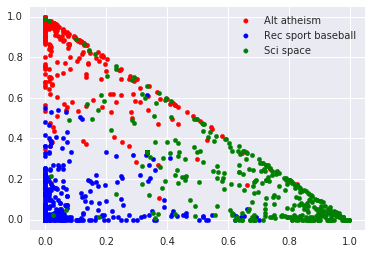

In [467]:
plot_probabilities(alt_atheism_prob_test, col='red', legend='Alt atheism')
plot_probabilities(sport_baseball_prob_test, col='blue', legend='Rec sport baseball')
plot_probabilities(sci_space_prob_test, col='green', legend='Sci space')
pylab.ylim([-0.05,1.05])
pylab.xlim([-0.05,1.05])
plt.legend(loc='upper right')
plt.show()

## Observations:

From the above plot, we see that there LDA correctly produces three clusters, one corresponding to each news group. 